Retrieving Phonetic Embeddings

In [1]:
import sys
from argparse import ArgumentParser, RawTextHelpFormatter
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize

class Dictionary:
    def __init__(self, filepath, encoding="latin1"):
        self.words = list()
        self.lookup = dict()
        dictionary = list()
        print("loading...", file=sys.stderr)
        for i, line in enumerate(open(filepath, encoding=encoding)):
            line = line.strip()
            word, vec_s = line.split("  ")
            vec = [float(n) for n in vec_s.split()]
            self.lookup[word] = i
            dictionary.append(vec)
            self.words.append(word)
        print(f'Total words: {len(self.words)}', file=sys.stderr)
        self.dictionary = np.array(dictionary)
        self.norms = normalize(self.dictionary, axis=1)
        print('min Norm', np.min(self.norms))
        print('max Norm', np.max(self.norms))

    def vec(self, word):
        return self.dictionary[self.lookup[word.strip().upper()], :]

    def score(self, word1, word2):
        v1 = self.norms[self.lookup[word1.strip().upper()], :]
        v2 = self.norms[self.lookup[word2.strip().upper()], :]
        return np.sum(v1*v2)

    def word(self, vec, n=None):
        v = vec / np.linalg.norm(vec)
        dots = np.dot(self.norms, v)
        if n is None:
            return self.words[np.argmax(dots)]
        return [(self.words[x], dots[x]) for x in np.argsort(-dots)[:n]]

In [2]:
d = Dictionary("/kaggle/input/psych-project-dataset/simvecs")

loading...


min Norm -0.6210165606884935
max Norm 0.6102571871129993


Total words: 133860


In [3]:
# v = d.vec('look')
# print(v.shape, d.word(v))
# print(d.word(d.vec('two'), 10))

In [4]:
glove_file = "/kaggle/input/glove-300-psych/glove.6B.300d.txt"

embeddings = {}
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = [float(val) for val in values[1:]]
        embeddings[word] = vector


In [5]:
import csv
import string

tsv_file = "/kaggle/input/psych-project-dataset/processed_RTs.tsv"

unique_words = set()

df1 = pd.read_csv(tsv_file, sep='\t')

with open(tsv_file, newline='') as file:
    reader = csv.DictReader(file, delimiter='\t')
    for row in reader:
        word = row['word']
        cleaned_word = ''.join(char for char in word if char.isalpha())
        unique_words.add(cleaned_word.lower())

len(unique_words)

2364

In [6]:
semantic_embeddings = {}
for word in unique_words:
    if word in embeddings:
        semantic_embeddings[word] = embeddings[word]


In [7]:
phonetic_embeddings = {}

for word in unique_words:
    try:
        embedding = d.vec(word.lower())
        phonetic_embeddings[word] = embedding
    except KeyError:
        try:
            embedding = d.vec(word.upper())
            phonetic_embeddings[word] = embedding
        except KeyError:
            pass


In [8]:
import pandas as pd

common_words_all = set(unique_words).intersection(semantic_embeddings.keys(), phonetic_embeddings.keys())
common_words_data = []

for word in common_words_all:
    common_words_data.append((word, phonetic_embeddings[word], semantic_embeddings[word]))

df = pd.DataFrame(common_words_data, columns=['word', 'Phonetic Embedding', 'Semantic Embedding'])

In [9]:
import pandas as pd
import re

df_fine = df1.groupby('word')['meanItemRT'].mean().reset_index()
df_fine = df_fine.drop_duplicates(subset='word', keep='first')
df_fine['word'] = df_fine['word'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df_fine['word'] = df_fine['word'].str.lower()
df_fine.reset_index(drop=True, inplace=True)
print(df_fine)

         word  meanItemRT
0     admiral  426.092105
1          ah  323.963415
2       based  351.985714
3       budge  349.493671
4         but  341.776471
...       ...         ...
3099      you  336.218391
3100      you  377.931034
3101      you  355.048193
3102    young  336.930481
3103     your  308.141618

[3104 rows x 2 columns]


In [10]:
merged_df = pd.merge(df, df_fine, on='word', how='inner')

# Display the resulting merged DataFrame
print(merged_df)

            word                                 Phonetic Embedding  \
0          agree  [-0.008384373, -1.8298608, -0.23563088, -0.776...   
1         pajama  [-1.8243653, -0.5100818, -0.6523606, 1.0782421...   
2           pair  [-1.022913, 0.20142151, -0.5014199, 0.66651726...   
3       commerce  [-1.945937, 0.69846565, 0.633816, 1.0153291, -...   
4        staring  [-0.14638306, -1.6987596, -1.7438554, -0.63468...   
...          ...                                                ...   
2988      toward  [-0.32182792, -0.5070498, -1.8939165, -1.47961...   
2989      childs  [-0.45777476, -1.4322462, 0.15644078, -0.70827...   
2990     british  [-0.40473387, 0.11187869, -0.9147981, -2.6912,...   
2991      recent  [0.1735149, 0.24535327, -0.76614267, -1.081224...   
2992  journalist  [0.038056303, -1.1688482, 0.63912636, 0.054990...   

                                     Semantic Embedding  meanItemRT  
0     [0.31609, 0.27697, -0.28343, -0.11395, 0.19687...  308.048276  
1     [

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


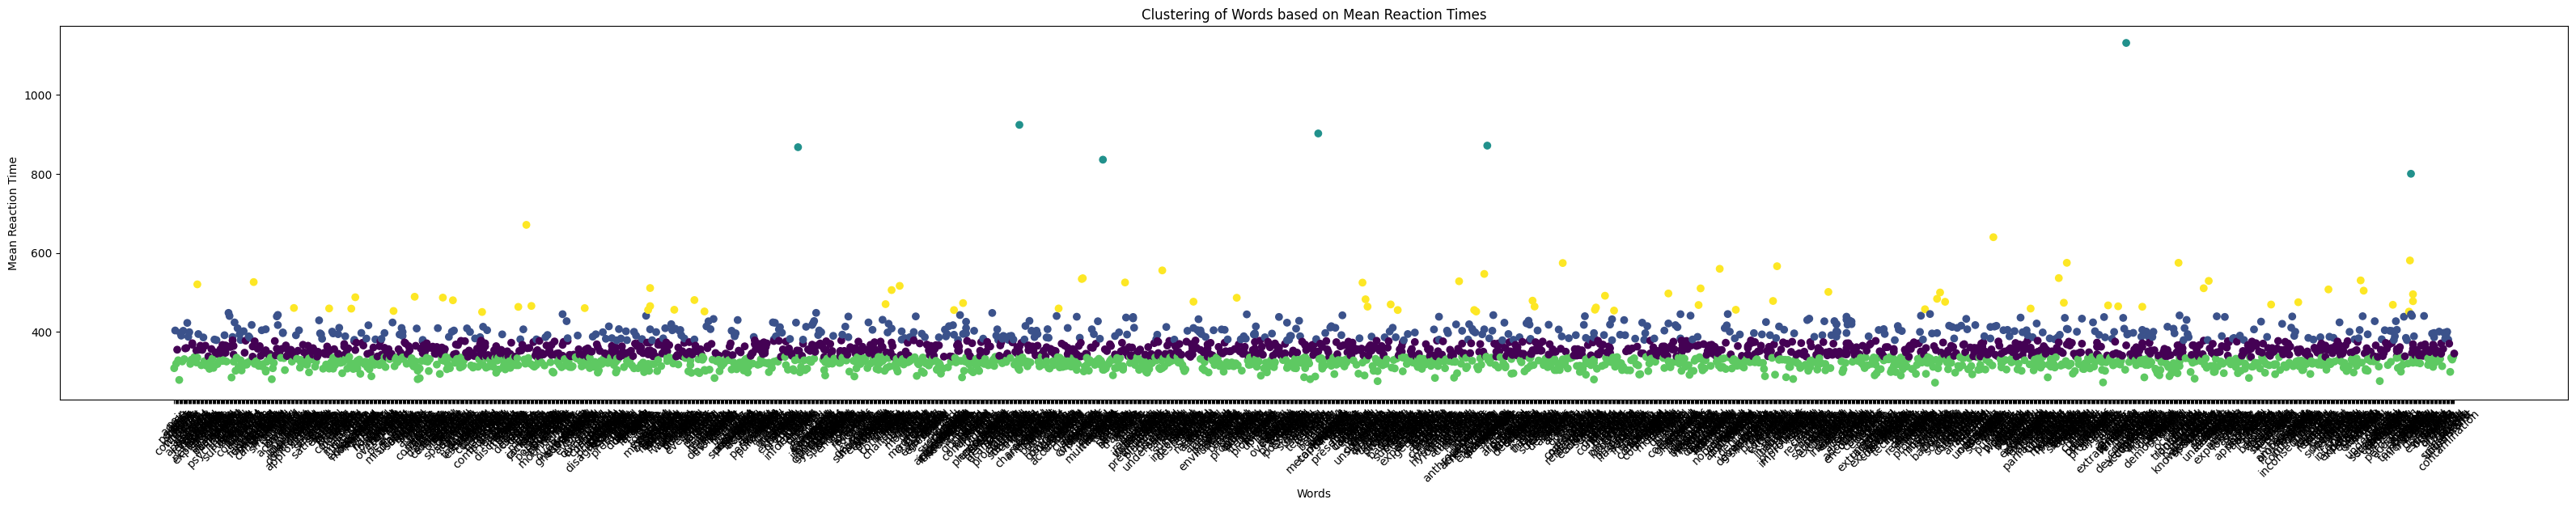

Data has been successfully written to merged_data_clustered.tsv


In [11]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

mean_rts = merged_df['meanItemRT'].values.reshape(-1, 1)

scaler = StandardScaler()
mean_rts_scaled = scaler.fit_transform(mean_rts)

kmeans = KMeans(n_clusters=5, random_state=42)

kmeans.fit(mean_rts_scaled)

merged_df['cluster'] = kmeans.labels_

plt.figure(figsize=(40, 6))
plt.scatter(merged_df['word'], merged_df['meanItemRT'], c=merged_df['cluster'], cmap='viridis')
plt.xlabel('Words')
plt.ylabel('Mean Reaction Time')
plt.title('Clustering of Words based on Mean Reaction Times')
plt.xticks(rotation=45)
plt.show()

output_file_path = 'merged_data_clustered.tsv'

merged_df.to_csv(output_file_path, sep='\t', index=False)

print(f"Data has been successfully written to {output_file_path}")

In [12]:
# import pandas as pd
# merger_df = merger_df.sort_values(by='cluster')

# df=merger_df

# embeddings_df = pd.DataFrame(columns=['Word Pair', 'Phonetic Embedding', 'Semantic Embedding'])

# for index, row in similarity_df.iterrows():
#     word_pair = row['Word Pair']
#     word1, word2 = word_pair

#     if df[df['word'] == word1]['cluster'].values == df[df['word'] == word2]['cluster'].values:
#         phonetic_embedding = row['Phonetic Embedding']
#         semantic_embedding = row['Semantic Embedding']

#         embeddings_df = embeddings_df.append({'Word Pair': word_pair,
#                                               'Phonetic Embedding': phonetic_embedding,
#                                               'Semantic Embedding': semantic_embedding},
#                                              ignore_index=True)

# print(embeddings_df)

In [13]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity

# phonetic_cosine_scores = {}
# semantic_cosine_scores = {}

# for cluster in merged_df['cluster'].unique():
#     cluster_data = merged_df[merged_df['cluster'] == cluster]

#     phonetic_embeddings = np.array(cluster_data['Phonetic Embedding'].tolist())
#     semantic_embeddings = np.array(cluster_data['Semantic Embedding'].tolist())

#     phonetic_cosine_matrix = cosine_similarity(phonetic_embeddings)
#     semantic_cosine_matrix = cosine_similarity(semantic_embeddings)

#     phonetic_cosine_scores[cluster] = phonetic_cosine_matrix
#     semantic_cosine_scores[cluster] = semantic_cosine_matrix

# cosine_similarity_data = []

# for cluster, cluster_data in merged_df.groupby('cluster'):
#     phonetic_cosine_matrix = phonetic_cosine_scores[cluster]

#     semantic_cosine_matrix = semantic_cosine_scores[cluster]

#     for i, word1 in enumerate(cluster_data['word']):
#         for j, word2 in enumerate(cluster_data['word']):
#             if i != j:
#                 phonetic_similarity = phonetic_cosine_matrix[i, j]
#                 semantic_similarity = semantic_cosine_matrix[i, j]

#                 cosine_similarity_data.append({
#                     'Word Pair': f'({word1}, {word2})',
#                     'Phonetic Cosine Similarity': phonetic_similarity,
#                     'Semantic Cosine Similarity': semantic_similarity
#                 })

# cosine_similarity_df = pd.DataFrame(cosine_similarity_data)

# print(cosine_similarity_df)

In [14]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity

# phonetic_cosine_scores = {}
# semantic_cosine_scores = {}

# for cluster in merged_df['cluster'].unique():
#     cluster_data = merged_df[merged_df['cluster'] == cluster]

#     phonetic_embeddings = np.array(cluster_data['Phonetic Embedding'].tolist())
#     semantic_embeddings = np.array(cluster_data['Semantic Embedding'].tolist())

#     phonetic_cosine_matrix = np.abs(cosine_similarity(phonetic_embeddings))

#     semantic_cosine_matrix = np.abs(cosine_similarity(semantic_embeddings))

#     phonetic_cosine_scores[cluster] = phonetic_cosine_matrix
#     semantic_cosine_scores[cluster] = semantic_cosine_matrix

# cluster_dfs = {}
# for cluster, cluster_data in merged_df.groupby('cluster'):
#     phonetic_cosine_matrix = phonetic_cosine_scores[cluster]

#     semantic_cosine_matrix = semantic_cosine_scores[cluster]
#     cosine_similarity_data = []

#     for i, word1 in enumerate(cluster_data['word']):
#         for j, word2 in enumerate(cluster_data['word']):
#             if i != j:
#                 phonetic_similarity = phonetic_cosine_matrix[i, j]
#                 semantic_similarity = semantic_cosine_matrix[i, j]

#                 cosine_similarity_data.append({
#                     'Word Pair': f'({word1}, {word2})',
#                     'Phonetic Cosine Similarity': phonetic_similarity,
#                     'Semantic Cosine Similarity': semantic_similarity
#                 })

#     cluster_df = pd.DataFrame(cosine_similarity_data)

#     cluster_df['Cluster'] = cluster
#     cluster_dfs[cluster] = cluster_df

# for cluster, df in cluster_dfs.items():
#     print(f"Cluster {cluster} DataFrame:")
#     print(df)
#     print()


In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# Assume data contains the data DataFrame

# Initialize empty dictionaries to store cosine scores for each cluster
phonetic_cosine_scores = {}
semantic_cosine_scores = {}

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Iterate through each cluster
for cluster in merged_df['cluster'].unique():
    # Filter the data for the current cluster
    cluster_data = merged_df[merged_df['cluster'] == cluster]

    # Extract the phonetic embeddings and semantic embeddings for the cluster
    phonetic_embeddings = np.array(cluster_data['Phonetic Embedding'].tolist())
    semantic_embeddings = np.array(cluster_data['Semantic Embedding'].tolist())

    # Calculate cosine similarity between pairs of phonetic embeddings
    phonetic_cosine_matrix = cosine_similarity(phonetic_embeddings)
    phonetic_cosine_matrix_scaled = scaler.fit_transform(phonetic_cosine_matrix)

    # Calculate cosine similarity between pairs of semantic embeddings
    semantic_cosine_matrix = cosine_similarity(semantic_embeddings)
    semantic_cosine_matrix_scaled = scaler.fit_transform(semantic_cosine_matrix)

    # Store the scaled cosine similarity matrices in the dictionaries
    phonetic_cosine_scores[cluster] = phonetic_cosine_matrix_scaled
    semantic_cosine_scores[cluster] = semantic_cosine_matrix_scaled

# Initialize an empty dictionary to store DataFrames for each cluster
cluster_dfs = {}

# Iterate through each cluster
for cluster, cluster_data in merged_df.groupby('cluster'):
    # Extract the phonetic cosine similarity matrix for the cluster
    phonetic_cosine_matrix_scaled = phonetic_cosine_scores[cluster]

    # Extract the semantic cosine similarity matrix for the cluster
    semantic_cosine_matrix_scaled = semantic_cosine_scores[cluster]

    # Initialize an empty list to store dictionaries of cosine similarity scores
    cosine_similarity_data = []

    # Iterate through each pair of words in the cluster
    for i, word1 in enumerate(cluster_data['word']):
        for j, word2 in enumerate(cluster_data['word']):
            # Skip if the pair of words are the same
            if i != j:
                # Extract the cosine similarity scores for the current pair of words
                phonetic_similarity = phonetic_cosine_matrix_scaled[i, j]
                semantic_similarity = semantic_cosine_matrix_scaled[i, j]

                # Add the cosine similarities to the list
                cosine_similarity_data.append({
                    'Word Pair': f'({word1}, {word2})',
                    'Phonetic Cosine Similarity': phonetic_similarity,
                    'Semantic Cosine Similarity': semantic_similarity
                })

    # Create a new DataFrame from the list of dictionaries
    cluster_df = pd.DataFrame(cosine_similarity_data)

    # Add the cluster column
    cluster_df['Cluster'] = cluster

    # Store the DataFrame in the dictionary
    cluster_dfs[cluster] = cluster_df

# Print the DataFrames for each cluster
for cluster, df in cluster_dfs.items():
    print(f"Cluster {cluster} DataFrame:")
    print(df)
    print()


Cluster 0 DataFrame:
                           Word Pair  Phonetic Cosine Similarity  \
0                  (commerce, brunt)                    0.100336   
1                  (commerce, slate)                    0.158843   
2                   (commerce, play)                    0.138353   
3                   (commerce, play)                    0.138353   
4                 (commerce, figure)                    0.145823   
...                              ...                         ...   
1275765          (journalist, based)                    0.454471   
1275766          (journalist, ships)                    0.204298   
1275767          (journalist, ships)                    0.204298   
1275768          (journalist, brass)                    0.138953   
1275769  (journalist, contamination)                    0.215996   

         Semantic Cosine Similarity  Cluster  
0                          0.103839        0  
1                          0.107873        0  
2                    

In [16]:
# Initialize empty dictionaries to store average scores for each cluster
average_scores = {'Cluster': [], 'Average Phonetic Cosine Similarity': [], 'Average Semantic Cosine Similarity': []}

# Iterate through each cluster DataFrame
for cluster, df in cluster_dfs.items():
    # Calculate the average scores for the current cluster
    avg_phonetic_similarity = df['Phonetic Cosine Similarity'].mean()
    avg_semantic_similarity = df['Semantic Cosine Similarity'].mean()

    # Append the average scores to the dictionary
    average_scores['Cluster'].append(cluster)
    average_scores['Average Phonetic Cosine Similarity'].append(avg_phonetic_similarity)
    average_scores['Average Semantic Cosine Similarity'].append(avg_semantic_similarity)

# Create a DataFrame from the dictionary
average_scores_df = pd.DataFrame(average_scores)

# Print the DataFrame
print("Average Cosine Similarity Scores for Each Cluster:")
print(average_scores_df)


Average Cosine Similarity Scores for Each Cluster:
   Cluster  Average Phonetic Cosine Similarity  \
0        0                            0.212648   
1        1                            0.213168   
2        2                            0.127961   
3        3                            0.211195   
4        4                            0.188101   

   Average Semantic Cosine Similarity  
0                            0.271298  
1                            0.233375  
2                            0.106766  
3                            0.329944  
4                            0.180923  


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import ast

In [18]:
merged_df

,word,Phonetic Embedding,Semantic Embedding,meanItemRT,cluster
0,agree,"[-0.008384373, -1.8298608, -0.23563088, -0.776...","[0.31609, 0.27697, -0.28343, -0.11395, 0.19687...",308.048276,3
1,pajama,"[-1.8243653, -0.5100818, -0.6523606, 1.0782421...","[0.251, -0.11243, -0.29678, -0.009211, -0.4043...",403.500000,1
2,pair,"[-1.022913, 0.20142151, -0.5014199, 0.66651726...","[-0.02059, 0.34758, -0.48154, -0.48798, -0.076...",319.582090,3
3,commerce,"[-1.945937, 0.69846565, 0.633816, 1.0153291, -...","[-0.13187, -0.42733, -0.21966, -0.18693, -0.21...",354.884615,0
4,staring,"[-0.14638306, -1.6987596, -1.7438554, -0.63468...","[0.12431, 0.38604, 0.20946, -0.20456, 0.03692,...",328.193182,3
...,...,...,...,...,...
2988,toward,"[-0.32182792, -0.5070498, -1.8939165, -1.47961...","[-0.3323, -0.22803, 0.67566, -0.26063, -0.1398...",298.708333,3
2989,childs,"[-0.45777476, -1.4322462, 0.15644078, -0.70827...","[0.099505, -0.18447, -0.044504, 0.31806, 0.199...",334.271739,3
2990,british,"[-0.40473387, 0.11187869, -0.9147981, -2.6912,...","[0.44361, -0.24175, 0.23657, 0.16535, -0.12898...",329.909091,3
2991,recent,"[0.1735149, 0.24535327, -0.76614267, -1.081224...","[0.38313, 0.066363, 0.3571, -0.0058642, 0.0658...",336.808824,3


In [19]:
# Convert string representations of embeddings to lists of numbers
def convert_embedding(embedding):
    try:
        return ast.literal_eval(embedding)
    except (SyntaxError, ValueError):
        return []

# all_embeds=[]
# for embedding in merged_df['Phonetic Embedding']:
#     emb=[]
#     for x in embedding[1:-1].split(" "):
#         if x != "":
#             emb.append(float(x.strip()))
#     all_embeds.append(emb)

# merged_df['Phonetic Embedding'] = all_embeds
# merged_df['Semantic Embedding'] = merged_df['Semantic Embedding'].apply(convert_embedding)

# Remove rows with missing or empty embeddings
merged_df = merged_df.dropna(subset=['Phonetic Embedding', 'Semantic Embedding'])

# Split data into features (embeddings) and target variable
X_phonetic = np.array(merged_df['Phonetic Embedding'].tolist())
X_semantic = np.array(merged_df['Semantic Embedding'].tolist())
y = merged_df['meanItemRT']

In [20]:
# Split data into training and testing sets
X_phonetic_train, X_phonetic_test, y_train, y_test = train_test_split(X_phonetic, y, test_size=0.2, random_state=42)
X_semantic_train, X_semantic_test, _, _ = train_test_split(X_semantic, y, test_size=0.2, random_state=42)

# Train models
phonetic_model = RandomForestRegressor()
phonetic_model.fit(X_phonetic_train, y_train)

semantic_model = RandomForestRegressor()
semantic_model.fit(X_semantic_train, y_train)
# Debugging statements
print("X_phonetic_train shape:", X_phonetic_train.shape)
print("X_semantic_train shape:", X_semantic_train.shape)
print("y_train shape:", y_train.shape)

X_phonetic_train shape: (2394, 50)
X_semantic_train shape: (2394, 300)
y_train shape: (2394,)


In [21]:
# Evaluate models
phonetic_preds = phonetic_model.predict(X_phonetic_test)
semantic_preds = semantic_model.predict(X_semantic_test)

# Calculate MSE
phonetic_mse = mean_squared_error(y_test, phonetic_preds)
semantic_mse = mean_squared_error(y_test, semantic_preds)

print("Phonetic Embedding Model MSE:", phonetic_mse)
print("Semantic Embedding Model MSE:", semantic_mse)

Phonetic Embedding Model MSE: 3330.195209550311
Semantic Embedding Model MSE: 3263.6665450283517


In [22]:
df_gpt = pd.read_csv('/kaggle/input/gpt3-probs-psych/all_stories_gpt3.csv')
df_gpt= df_gpt[['token','logprob']]

# Find common entries between 'word' column in merged_df and 'token' column in df_gpt
common_entries = len(set(merged_df['word']).intersection(set(df_gpt['token'])))

# Display the number of common entries
print("Number of common entries between 'word' and 'token':", common_entries)


Number of common entries between 'word' and 'token': 50


In [23]:
# Rename the 'token' column in df_gpt to 'word'
df_gpt.rename(columns={'token': 'word'}, inplace=True)

# Merge the DataFrames on common words
merged_data = pd.merge(df_gpt, merged_df, on='word', how='inner')

# Display the merged DataFrame
print(merged_data.head())

  word   logprob                                 Phonetic Embedding  \
0   be -3.714682  [0.14430255, 2.2145545, -0.43825728, -0.932971...   
1   or -0.366135  [0.46570462, 0.3484546, -0.79099095, 1.1768112...   
2   or -0.366135  [0.46570462, 0.3484546, -0.79099095, 1.1768112...   
3   us -0.044053  [-1.0565667, -0.47826365, -0.15297262, 0.60280...   
4   us -0.044053  [-1.0565667, -0.47826365, -0.15297262, 0.60280...   

                                  Semantic Embedding  meanItemRT  cluster  
0  [-0.33848, 0.42841, -0.10284, -0.22054, 0.0517...  326.505149        3  
1  [-0.26234, 0.12633, -0.084185, -0.077551, -0.0...  348.433735        0  
2  [-0.26234, 0.12633, -0.084185, -0.077551, -0.0...  359.608591        0  
3  [-0.0022629, -0.40326, -0.13662, -0.047524, -0...  413.826087        1  
4  [-0.0022629, -0.40326, -0.13662, -0.047524, -0...  322.621053        3  


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Preprocess the data
merged_data['word_length'] = merged_data['word'].apply(len)

# Model 1: Using Phonetic Embedding
X1 = np.column_stack((merged_data['word_length'], merged_data['Phonetic Embedding'].apply(np.mean), merged_data['logprob']))
y1 = merged_data['meanItemRT']

# Model 2: Using Semantic Embedding
X2 = np.column_stack((merged_data['word_length'], merged_data['Semantic Embedding'].apply(np.mean), merged_data['logprob']))
y2 = merged_data['meanItemRT']

# Split the data into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Train the models
model1 = LinearRegression()
model1.fit(X1_train, y1_train)

model2 = LinearRegression()
model2.fit(X2_train, y2_train)

# Predict
y1_pred = model1.predict(X1_test)
y2_pred = model2.predict(X2_test)

# Calculate RMSE
rmse1 = np.sqrt(mean_squared_error(y1_test, y1_pred))
rmse2 = np.sqrt(mean_squared_error(y2_test, y2_pred))

print("RMSE for Model 1:", rmse1)
print("RMSE for Model 2:", rmse2)


RMSE for Model 1: 34.7357216197476
RMSE for Model 2: 36.541885923597796


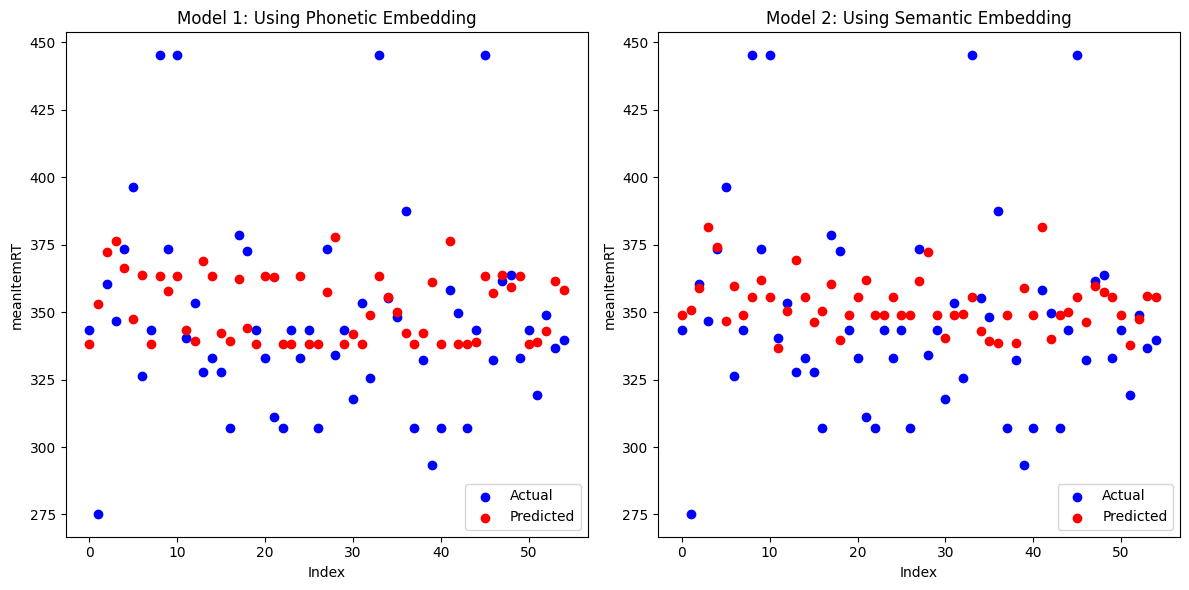

In [25]:
# Plot the graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(range(len(y1_test)), y1_test, color='b', label='Actual')
plt.scatter(range(len(y1_pred)), y1_pred, color='r', label='Predicted')
plt.title('Model 1: Using Phonetic Embedding')
plt.xlabel('Index')
plt.ylabel('meanItemRT')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(y2_test)), y2_test, color='b', label='Actual')
plt.scatter(range(len(y2_pred)), y2_pred, color='r', label='Predicted')
plt.title('Model 2: Using Semantic Embedding')
plt.xlabel('Index')
plt.ylabel('meanItemRT')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Preprocess the data
merged_df['word_length'] = merged_df['word'].apply(len)

# Model 1: Using Phonetic Embedding
X1 = np.column_stack((merged_df['word_length'], merged_df['Phonetic Embedding'].apply(np.mean)))
y1 = merged_df['meanItemRT']

# Model 2: Using Semantic Embedding
X2 = np.column_stack((merged_df['word_length'], merged_df['Semantic Embedding'].apply(np.mean)))
y2 = merged_df['meanItemRT']

# Split the data into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Train the models
model1 = LinearRegression()
model1.fit(X1_train, y1_train)

model2 = LinearRegression()
model2.fit(X2_train, y2_train)

# Predict
y1_pred = model1.predict(X1_test)
y2_pred = model2.predict(X2_test)

# Calculate RMSE
rmse1 = np.sqrt(mean_squared_error(y1_test, y1_pred))
rmse2 = np.sqrt(mean_squared_error(y2_test, y2_pred))

print("RMSE for Model 1:", rmse1)
print("RMSE for Model 2:", rmse2)


RMSE for Model 1: 55.58485501719134
RMSE for Model 2: 55.51790480547849


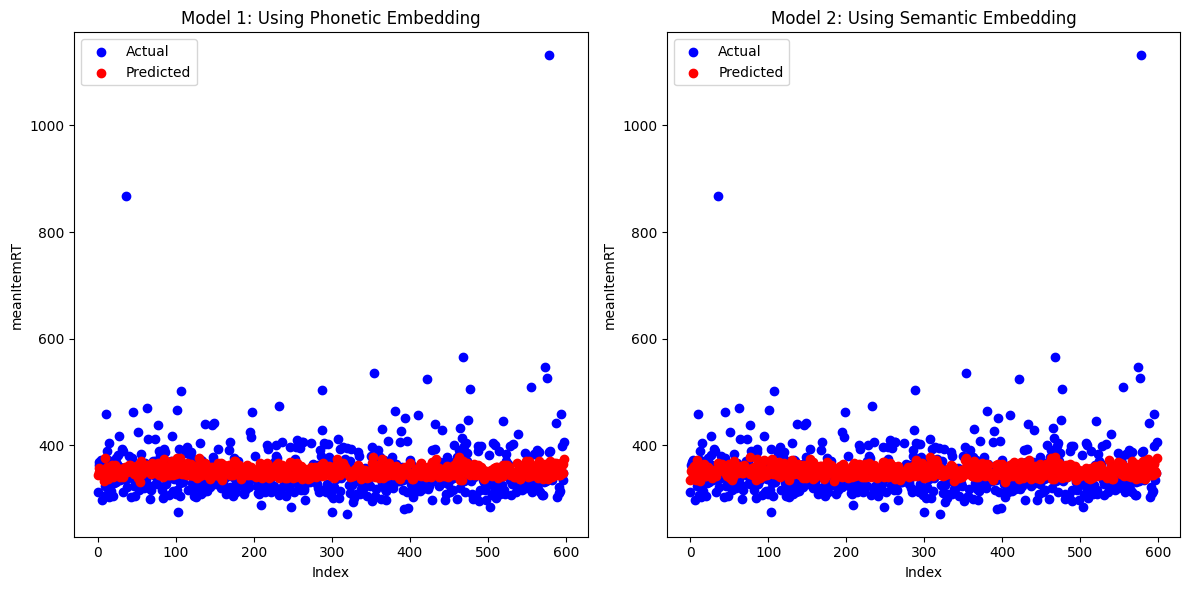

In [27]:
# Plot the graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(range(len(y1_test)), y1_test, color='b', label='Actual')
plt.scatter(range(len(y1_pred)), y1_pred, color='r', label='Predicted')
plt.title('Model 1: Using Phonetic Embedding')
plt.xlabel('Index')
plt.ylabel('meanItemRT')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(range(len(y2_test)), y2_test, color='b', label='Actual')
plt.scatter(range(len(y2_pred)), y2_pred, color='r', label='Predicted')
plt.title('Model 2: Using Semantic Embedding')
plt.xlabel('Index')
plt.ylabel('meanItemRT')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
#sankalp use this dataframe


import itertools
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import ast

# Function to parse string representations to lists, handling null bytes
def parse_embedding(s):
    try:
        if isinstance(s, str):
            # Replace null bytes with empty strings
            s = s.replace('\x00', '')
            # Parse the string to a list using ast.literal_eval
            return ast.literal_eval(s)
    except SyntaxError:
        print("SyntaxError occurred while parsing embedding:", s)
        return None
    return s

# Function to parse string representations of meanItemRT to lists
def parse_mean_item_rt(s):
    try:
        if isinstance(s, str):
            # Replace null bytes with empty strings
            s = s.replace('\x00', '')
            # Parse the string to a list using ast.literal_eval
            return ast.literal_eval(s)
    except SyntaxError:
        print("SyntaxError occurred while parsing meanItemRT:", s)
        return None
    return s

# Convert string representations of lists to actual lists, replacing null bytes
merged_df['Phonetic Embedding'] = merged_df['Phonetic Embedding'].apply(parse_embedding)
merged_df['Semantic Embedding'] = merged_df['Semantic Embedding'].apply(parse_embedding)
merged_df['meanItemRT'] = merged_df['meanItemRT'].apply(parse_mean_item_rt)

# Drop rows where parsing failed
merged_df = merged_df.dropna()

# Extract embeddings and mean reaction times from DataFrame
semantic_embeddings = np.array(merged_df['Semantic Embedding'].tolist())
phonetic_embeddings = np.array(merged_df['Phonetic Embedding'].tolist())
mean_reaction_times = np.array(merged_df['meanItemRT'].tolist())

# Function to compute pairwise cosine similarity between embeddings
def pairwise_cosine_similarity(embeddings):
    similarities = cosine_similarity(embeddings)
    return similarities[np.triu_indices(similarities.shape[0], k=1)]

# Compute pairwise cosine similarity between semantic embeddings
semantic_similarities = pairwise_cosine_similarity(semantic_embeddings)

# Compute pairwise cosine similarity between phonetic embeddings
phonetic_similarities = pairwise_cosine_similarity(phonetic_embeddings)

# Create all pairs of words
word_pairs = list(itertools.combinations(merged_df['word'], 2))

# Calculate the mean reaction time for each word
mean_reaction_time_dict = dict(zip(merged_df['word'], mean_reaction_times))
mean_rt_diffs = [abs(mean_reaction_time_dict[pair[0]] - mean_reaction_time_dict[pair[1]]) for pair in word_pairs]

# Create DataFrame with word pairs, cosine similarities, and mean reaction time differences
similarity_df = pd.DataFrame({
    'Word Pair': word_pairs,
    'Semantic Cosine Similarity': semantic_similarities,
    'Phonetic Cosine Similarity': phonetic_similarities,
    'Mean RT Difference': mean_rt_diffs
})

# Sort word pairs to remove duplicates
similarity_df['Sorted Word Pair'] = similarity_df['Word Pair'].apply(lambda x: tuple(sorted(x)))
# Drop duplicates based on sorted word pairs
similarity_df.drop_duplicates(subset='Sorted Word Pair', inplace=True)
# Drop the 'Sorted Word Pair' column
similarity_df.drop(columns=['Sorted Word Pair'], inplace=True)
# Reset the index
similarity_df.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
print(similarity_df)

                     Word Pair  Semantic Cosine Similarity  \
0              (agree, pajama)                   -0.105058   
1                (agree, pair)                    0.154045   
2            (agree, commerce)                    0.149927   
3             (agree, staring)                    0.003290   
4               (agree, quits)                    0.083458   
...                        ...                         ...   
2568993       (childs, recent)                   -0.107504   
2568994   (childs, journalist)                    0.000437   
2568995      (british, recent)                    0.278556   
2568996  (british, journalist)                    0.350071   
2568997   (recent, journalist)                    0.147619   

         Phonetic Cosine Similarity  Mean RT Difference  
0                          0.377165           95.451724  
1                          0.191999           11.533814  
2                         -0.007384           46.836340  
3                      

In [29]:
import pandas as pd

# Assuming similarity_df is your DataFrame
# Convert DataFrame to list of lists
data_list = similarity_df.values.tolist()
semantic_cosine_similarity_of_first_row = data_list[0][1]

# To access the mean RT difference of the second row:
mean_rt_difference_of_second_row = data_list[1][2]

In [30]:
import pandas as pd
from tqdm import tqdm

# Assuming similarity_df is your DataFrame
# Convert DataFrame to list of lists with all four values
data_list = []

# Iterate through DataFrame rows with tqdm
for _, row in tqdm(similarity_df.iterrows(), total=len(similarity_df), desc="Processing rows"):
    # Append values of each row as a list to data_list
    data_list.append(row.tolist())

# Accessing values as per your specification
# For example, to access the semantic cosine similarity of the first row:
semantic_cosine_similarity_of_first_row = data_list[0][1]

# To access the mean RT difference of the second row:
mean_rt_difference_of_second_row = data_list[1][3]

Processing rows: 100%|██████████| 2568998/2568998 [02:10<00:00, 19640.97it/s]


In [31]:
from tqdm import tqdm

t =  31.334798534798438
ph = 0
se = 0
pa = []
sa = []

# Iterate through data_list with tqdm
for i in tqdm(range(len(data_list)), desc="Processing data_list"):
    if data_list[i][3] >= t:   # not similar
        if data_list[i][1] >= data_list[i][2]:
            ph += abs(data_list[i][3] - t) + abs(data_list[i][1] - data_list[i][2])
            pa.append(ph)
            sa.append(0)
        else:
            se += abs(data_list[i][3] - t) + abs(data_list[i][1] - data_list[i][2])
            pa.append(0)
            sa.append(se)
    else:    # similar
        if data_list[i][1] <= data_list[i][2]:
            ph += abs(data_list[i][3] - t) + abs(data_list[i][1] - data_list[i][2])
            # se += -1 * (abs(data_list[i][3] - t) + abs(data_list[i][1] - data_list[i][2]))
            pa.append(ph)
            sa.append(0)
        else:
            se += abs(data_list[i][3] - t) + abs(data_list[i][1] - data_list[i][2])
            # ph += -1 * (abs(data_list[i][3] - t) + abs(data_list[i][1] - data_list[i][2]))
            pa.append(0)
            sa.append(se)

Processing data_list: 100%|██████████| 2568998/2568998 [00:04<00:00, 529315.73it/s]


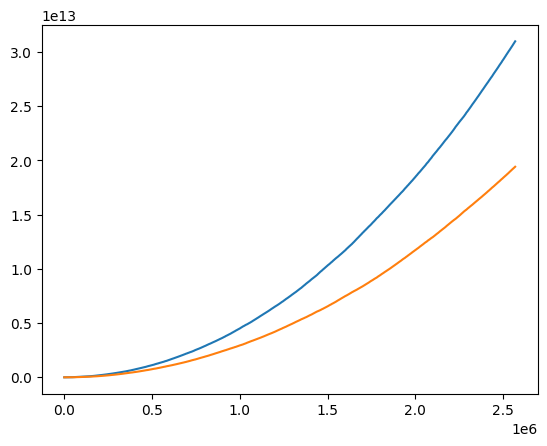

In [32]:
cum_sa = []
cum_sa_sum = 0
for num in sa:
    cum_sa_sum += num
    cum_sa.append(cum_sa_sum)

cum_pa = []
cum_pa_sum = 0
for num in pa:
    cum_pa_sum += num
    cum_pa.append(cum_pa_sum)

import matplotlib.pyplot as plt

plt.plot(cum_sa)
plt.plot(cum_pa)
plt.show()

In [33]:
import pandas as pd
import numpy as np
from itertools import combinations
from tqdm import tqdm
import random

# Function to calculate the mean of embedding vectors for a pair
def calculate_mean_embedding(pair):
    word1, word2 = pair
    idx1 = merged_df[merged_df['word'] == word1].index[0]
    idx2 = merged_df[merged_df['word'] == word2].index[0]
    phonetic_mean = np.mean([merged_df.at[idx1, 'Phonetic Embedding'], merged_df.at[idx2, 'Phonetic Embedding']], axis=0)
    semantic_mean = np.mean([merged_df.at[idx1, 'Semantic Embedding'], merged_df.at[idx2, 'Semantic Embedding']], axis=0)
    mean_rt_diff = abs(merged_df.at[idx1, 'meanItemRT'] - merged_df.at[idx2, 'meanItemRT'])
    return pd.DataFrame({
        'Word Pair': [pair],
        'Mean Phonetic Embedding': [phonetic_mean],
        'Mean Semantic Embedding': [semantic_mean],
        'Mean RT Difference': [mean_rt_diff]
    })

# Randomly select 100,000 pairs of words from merged_df
random_pairs = random.sample(list(combinations(merged_df['word'], 2)), 150000)

# Create an empty DataFrame to store results
pair_df = pd.DataFrame(columns=['Word Pair', 'Mean Phonetic Embedding', 'Mean Semantic Embedding', 'Mean RT Difference'])

# Calculate mean embeddings and mean RT differences for each random word pair
for pair in tqdm(random_pairs, desc="Calculating embeddings and mean RT differences", unit="pair"):
    pair_data = calculate_mean_embedding(pair)
    pair_df = pd.concat([pair_df, pair_data], ignore_index=True)

# Display the resulting DataFrame
print(pair_df.head())


Calculating embeddings and mean RT differences:   0%|          | 0/150000 [00:00<?, ?pair/s]/tmp/ipykernel_34/2024849587.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pair_df = pd.concat([pair_df, pair_data], ignore_index=True)
Calculating embeddings and mean RT differences: 100%|██████████| 150000/150000 [18:53<00:00, 132.34pair/s]


              Word Pair                            Mean Phonetic Embedding  \
0        (others, here)  [0.50337094, 0.045968099999999984, -0.54005782...   
1    (crowd, plummeted)  [-2.54189265, -0.024015709999999996, 1.0297749...   
2  (sniff, discussions)  [-0.34271432, -0.307829055, -0.059964978, -3.0...   
3          (year, head)  [-0.42585611999999995, 0.22106540000000002, 0....   
4        (soul, smiled)  [-2.1409047, -0.5913151750000001, -1.17589013,...   

                             Mean Semantic Embedding  Mean RT Difference  
0  [-0.19600499999999998, 0.0893385, -0.079878499...           10.753773  
1  [0.18566, 0.082235, 0.387765, 0.02920000000000...           56.241857  
2  [-0.0504615, 0.30501999999999996, 0.0209632, -...          539.312092  
3  [-0.319955, 0.1338, 0.0099005, 0.0289899999999...           30.323223  
4  [-0.08736500000000003, -0.22435049999999998, 0...           14.615447  


In [34]:
# Add another label called 'class'
pair_df['class'] = np.where(pair_df['Mean RT Difference'] > 31.334798534798438, 0, 1)

# Display the updated DataFrame
print(pair_df.head())


              Word Pair                            Mean Phonetic Embedding  \
0        (others, here)  [0.50337094, 0.045968099999999984, -0.54005782...   
1    (crowd, plummeted)  [-2.54189265, -0.024015709999999996, 1.0297749...   
2  (sniff, discussions)  [-0.34271432, -0.307829055, -0.059964978, -3.0...   
3          (year, head)  [-0.42585611999999995, 0.22106540000000002, 0....   
4        (soul, smiled)  [-2.1409047, -0.5913151750000001, -1.17589013,...   

                             Mean Semantic Embedding  Mean RT Difference  \
0  [-0.19600499999999998, 0.0893385, -0.079878499...           10.753773   
1  [0.18566, 0.082235, 0.387765, 0.02920000000000...           56.241857   
2  [-0.0504615, 0.30501999999999996, 0.0209632, -...          539.312092   
3  [-0.319955, 0.1338, 0.0099005, 0.0289899999999...           30.323223   
4  [-0.08736500000000003, -0.22435049999999998, 0...           14.615447   

   class  
0      1  
1      0  
2      0  
3      1  
4      1  


In [35]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split



# Convert embeddings to numpy arrays
pair_df['Mean Phonetic Embedding'] = pair_df['Mean Phonetic Embedding'].apply(np.array)

# Prepare data
X = np.stack(pair_df['Mean Phonetic Embedding'].values)
y = pair_df['class'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(50, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluation
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print("Accuracy:", accuracy)


Accuracy: 0.5740333333333333


In [36]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Convert embeddings to numpy arrays
pair_df['Mean Semantic Embedding'] = pair_df['Mean Semantic Embedding'].apply(np.array)

# Prepare data
X = np.stack(pair_df['Mean Semantic Embedding'].values)
y = pair_df['class'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Define neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(300, 64)  # Adjusted input size
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Evaluation
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print("Accuracy:", accuracy)


Accuracy: 0.6784


In [37]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Load data
# Convert embeddings to numpy arrays
X = np.stack(pair_df['Mean Semantic Embedding'].values)
y = pair_df['class'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Convert to float for calculation
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  # Convert to float for calculation

# Define neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(300, 64)  # Adjusted input size to match semantic embedding dimension
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.long())  # Use CrossEntropyLoss, so labels should be long
    loss.backward()
    optimizer.step()

# Evaluation
with torch.no_grad():
    outputs = model(X_test_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    differences = torch.abs(probabilities[:, 1] - y_test_tensor)
    accuracy = 1.0 - torch.mean(differences).item()  # 1.0 - Mean absolute difference
    print("Accuracy:", accuracy)


Accuracy: 0.5713040232658386


In [38]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split



# Convert embeddings to numpy arrays
X = np.stack(pair_df['Mean Phonetic Embedding'].values)
y = pair_df['class'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Convert to float for calculation
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)  # Convert to float for calculation

# Define neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(50, 64)  # Adjusted input size to match phonetic embedding dimension
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.long())  # Use CrossEntropyLoss, so labels should be long
    loss.backward()
    optimizer.step()

# Evaluation
with torch.no_grad():
    outputs = model(X_test_tensor)
    probabilities = torch.softmax(outputs, dim=1)
    differences = torch.abs(probabilities[:, 1] - y_test_tensor)
    accuracy = 1.0 - torch.mean(differences).item()  # 1.0 - Mean absolute difference
    print("Accuracy:", accuracy)


Accuracy: 0.5142704546451569
